<a href="https://colab.research.google.com/github/parikhshyamal1993/Grammar_Check_Application/blob/main/Fine_tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This note book is for fine tuning bert for sentence classification task

1. Using publice dataset for the task colo_
2. preparing dataset from strach for better control and better undeerstanding 
3. fine tuning bert for classification task 
4. validating on validation set for accuray  

In [ ]:
! git  clone https://github.com/PacktPublishing/Transformers-for-Natural-Language-Processing.git


fatal: destination path 'Transformers-for-Natural-Language-Processing' already exists and is not an empty directory.


In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 
import tensorflow as tf
device_name  = tf.test.gpu_device_name()
if device_name=="/device:GPU:0":
  print("GPU device found : ",device_name)
else:
  print("GPU not found")

GPU device found :  /device:GPU:0


In [ ]:
import transformers
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset , DataLoader , RandomSampler , SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer , BertConfig ,BertModel
from transformers import AdamW , BertForSequenceClassification,get_linear_schedule_with_warmup
from tqdm import tqdm , trange
import io
import torch
import  matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:


train_raw_data = pd.read_csv("/content/Transformers-for-Natural-Language-Processing/Chapter02/in_domain_train.tsv",
                             delimiter='\t',
                             header=None,
                             names=['sentence_source','label','labels_notes','sentence']
                              )

In [ ]:
train_raw_data.sample(10)

,sentence_source,label,labels_notes,sentence
5936,c_13,1,NaN,louis was forgiven .
1909,r-67,0,*,the time bomb had a snake behind the car which...
5553,b_73,0,*,they may grow as much as bamboo high .
4722,ks08,0,*,six inches were grown by the boy .
2340,l-93,1,NaN,mira blamed the accident on terry .
8375,ad03,1,NaN,gomez 's photograph of pugsley belonging to lu...
3472,ks08,1,NaN,little evidence was provided .
8420,ad03,0,*,not reading of shakespeare satisfied me
3523,ks08,1,NaN,i am hoping that the weather is lovely today .
105,cj99,1,NaN,"the more that you eat , the less that you want ."


In [ ]:


sentence = train_raw_data.sentence.values
sentences = ["[CLS]" + sent + "[SEP]" for sent in sentence]
labels = train_raw_data.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence :")
print(tokenized_texts[0])


Tokenize the first sentence :
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [ ]:
Max_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids , maxlen=Max_LEN,dtype="long",truncating="post",padding="post")

In [ ]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
train_inputs , validation_inputs , train_labels , validation_labels = train_test_split(input_ids,labels,random_state=2018,test_size=0.1)
train_masks , validation_masks , _,_ = train_test_split(attention_masks,input_ids,random_state=2018,test_size=0.1)

In [ ]:
print(len(train_inputs) , len(validation_inputs) , len(train_labels) , len(validation_labels))

7695 856 7695 856


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_label = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [ ]:
print(len(validation_inputs))
print(len(validation_label))
print(len(validation_masks))

856
856
856


In [ ]:
batch_size = 32

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_label) 
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader( validation_data , sampler=validation_sampler,batch_size = batch_size)


In [ ]:

configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config
print(configuration)


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias','LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params':[p for n , p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate':0.1},
    {'params':[p for n , p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate':0.0}
]

In [ ]:
epochs = 20

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr = 2e-5,
    eps = 1e-8,
    )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
 def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat==labels_flat) / len(labels_flat)
  


In [ ]:
t = []
train_loss_set = []

for _ in trange(epochs,desc="Epoch"):

  model.train()
  tr_loss = 0
  nb_tr_examples , nb_tr_steps = 0 , 0 

  for setp , batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids  , b_input_mask , b_labels = batch
    optimizer.zero_grad()
    output = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask,labels=b_labels)
    loss = output['loss']
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    tr_loss += loss.item()
    nb_tr_examples +=b_input_ids.size(0)
    nb_tr_steps+=1

  print("Train loss: {} ".format(tr_loss/nb_tr_steps))

  model.eval()

  eval_loss , eval_accuracy = 0 , 0 
  nb_eval_steps , nb_eval_examples = 0 , 0

  for batch in validation_dataloader:

    batch= tuple(t.to(device) for t in batch)

    b_input_ids , b_input_mask , b_labels = batch

    with torch.no_grad():
      logits= model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask)


    logits = logits['logits'].detach().cpu().numpy()
    label_ids  = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits,label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps+=1
  print("Validation Accuracy:{}".format(eval_accuracy/nb_eval_steps))




Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.14899913433753728 


Epoch:   5%|▌         | 1/20 [02:41<51:10, 161.61s/it]

Validation Accuracy:0.8179012345679012
Train loss: 0.11115459301335065 


Epoch:  10%|█         | 2/20 [05:22<48:21, 161.17s/it]

Validation Accuracy:0.8097993827160493
Train loss: 0.07700963939358461 


Epoch:  15%|█▌        | 3/20 [08:03<45:37, 161.01s/it]

Validation Accuracy:0.8225308641975309
Train loss: 0.05938356473203362 


Epoch:  20%|██        | 4/20 [10:43<42:53, 160.84s/it]

Validation Accuracy:0.8055555555555556
Train loss: 0.05434414352912502 


Epoch:  25%|██▌       | 5/20 [13:24<40:10, 160.68s/it]

Validation Accuracy:0.8252314814814815
Train loss: 0.04280133219097675 


Epoch:  30%|███       | 6/20 [16:04<37:27, 160.56s/it]

Validation Accuracy:0.8067129629629629
Train loss: 0.029173483379393877 


Epoch:  35%|███▌      | 7/20 [18:44<34:45, 160.44s/it]

Validation Accuracy:0.8148148148148148
Train loss: 0.029360881079127432 


Epoch:  40%|████      | 8/20 [21:24<32:04, 160.34s/it]

Validation Accuracy:0.8267746913580247
Train loss: 0.020202421042218 


Epoch:  45%|████▌     | 9/20 [24:05<29:24, 160.45s/it]

Validation Accuracy:0.8190586419753086
Train loss: 0.019673591586654906 


Epoch:  50%|█████     | 10/20 [26:45<26:43, 160.37s/it]

Validation Accuracy:0.8136574074074074
Train loss: 0.011433977816791053 


Epoch:  55%|█████▌    | 11/20 [29:25<24:02, 160.25s/it]

Validation Accuracy:0.8198302469135803
Train loss: 0.010754435517606848 


Epoch:  60%|██████    | 12/20 [32:05<21:21, 160.20s/it]

Validation Accuracy:0.82445987654321
Train loss: 0.01531402695539052 


Epoch:  65%|██████▌   | 13/20 [34:46<18:41, 160.19s/it]

Validation Accuracy:0.8182870370370371
Train loss: 0.008969824089469674 


Epoch:  70%|███████   | 14/20 [37:26<16:01, 160.21s/it]

Validation Accuracy:0.8171296296296297
Train loss: 0.011164074938157883 


Epoch:  75%|███████▌  | 15/20 [40:06<13:21, 160.28s/it]

Validation Accuracy:0.8252314814814815
Train loss: 0.008045851956053996 


Epoch:  80%|████████  | 16/20 [42:47<10:41, 160.37s/it]

Validation Accuracy:0.8171296296296297
Train loss: 0.00855840842289796 


Epoch:  85%|████████▌ | 17/20 [45:28<08:01, 160.49s/it]

Validation Accuracy:0.8209876543209877
Train loss: 0.007626509166811013 


Epoch:  90%|█████████ | 18/20 [48:08<05:21, 160.58s/it]

Validation Accuracy:0.8240740740740741
Train loss: 0.005282229660148925 


Epoch:  95%|█████████▌| 19/20 [50:49<02:40, 160.58s/it]

Validation Accuracy:0.8209876543209877
Train loss: 0.004519034969087601 


Epoch: 100%|██████████| 20/20 [53:29<00:00, 160.50s/it]

Validation Accuracy:0.8209876543209877


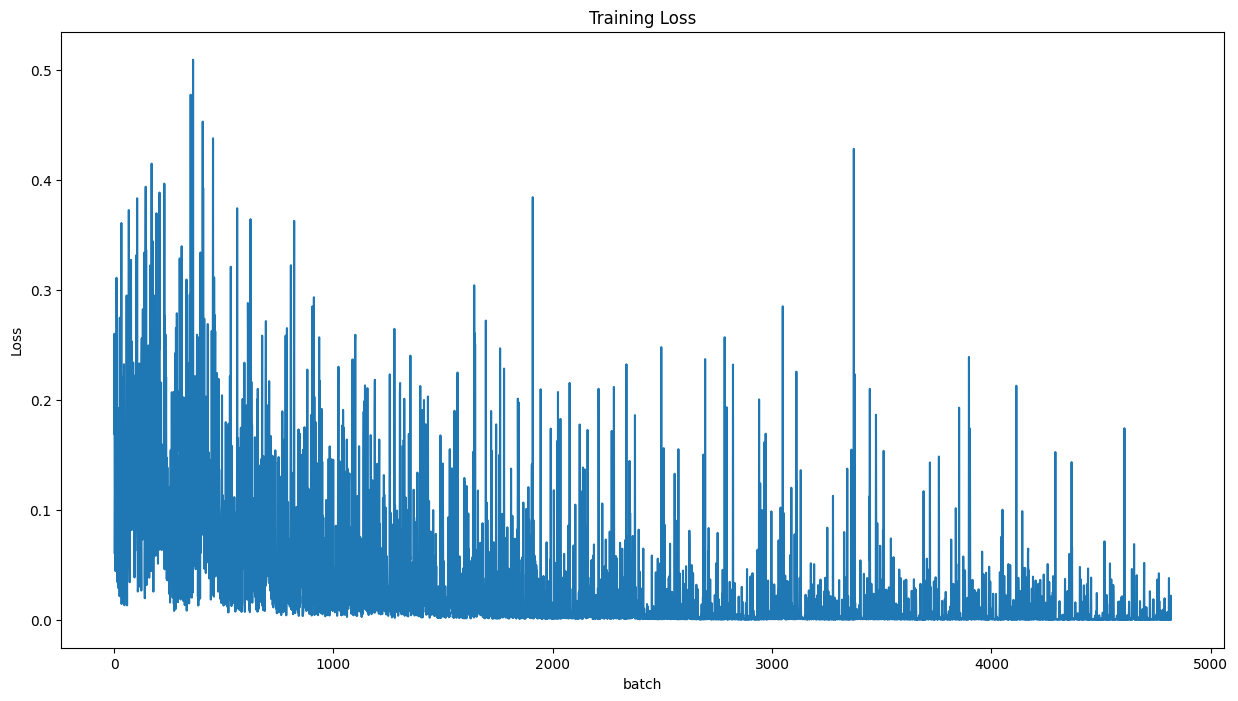

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training Loss")
plt.xlabel("batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
output_dir = "/content/gdrive/MyDrive/model_save"

# if not os.path.exists(output_dir):
#   os.makedirs(output_dir)

# model_to_save = model.module if hasattr(model,'module') else model
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)


Mounted at /content/gdrive


In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/model_save/")

NameError: ignored

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification","/content/gdrive/MyDrive/model_save/")


In [ ]:
classifier("India, officially the Republic of India (ISO: Bhārat Gaṇarājya),[25] is a country in South Asia. It is the seventh-largest country by area, the most populous country in the world, and the most populous democracy.[26][27] Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[j] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand, Myanmar, and Indonesia.")